In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

# Material Model

The goal of this notebook is to improve the material model

In [2]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
from graphmodels.validation import score_model, plot_diagnostic, plot_baseline_vs_computation
from graphmodels.data_utils import data_dict_from_db, get_X_y_from_data

In [15]:
Waste_nodes = {'PCS': {'type': 'parameter',
                       'name': 'Physical Capital Stock',
                       'unit': '$'},
               'DCGS': {'type': 'parameter',
                        'name': 'Durable Consumption Good Stock',
                        'unit': '$'},
               'RC': {'type': 'parameter',
                      'name': 'Rate of Capital Depreciation',
                      'unit': '%'},
               'PDCG': {'type': 'parameter',
                        'name': 'Proportion of Durable Consumption Goods Discarded',
                        'unit': '1'},
               'DSES': {'type': 'variable',
                        'name': 'Discarded Socio-Economic Stock',
                        'unit': 'tonnes',
                        'computation': lambda ME1, RC, PCS, PDCG, DCGS, **kwargs: ME1 * (RC * PCS + PDCG * DCGS)
                        },
               'RR': {'type': 'input', 'name': 'Recycling Ratio', 'unit': '1'},
               'WASTE': {'type': 'output',
                         'name': 'Waste Generated',
                         'unit': 'tonnes',
                         'computation': lambda DSES, RR, **kwargs: DSES * (1 - RR) # to be checked
                         },
               'ME1': {'type': 'input', 'name': 'DMC per GDP', 'unit': 'tonnes/$'}}


VDMC_nodes = {'DEi': {'type': 'input',
                     'name': 'Domestic Extraction per material',
                     'unit': 'tonnes'},
              'IMPi': {'type': 'input', 'name': 'Imports per material', 'unit': 'tonnes'},
              'EXPi': {'type': 'input', 'name': 'Exports per material', 'unit': 'tonnes'},
              'DMCi': {'type': 'output',
                       'name': 'Domestic material consumption per material',
                       'unit': 'tonnes',
                       'computation': lambda DEi, IMPi, EXPi, **kwargs: DEi + IMPi - EXPi
                       }
              }

ME2_nodes = {'MF': {'type': 'variable', 'name': 'Material footprint', 'unit': 'tonnes'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'ME2': {'type': 'output',
                     'name': 'MF per capita',
                     'unit': 'tonnes/capita',
                     'computation': lambda MF, Pop, **kwargs: MF / Pop
                     }
             }


ME1_nodes = {'DMC': {'type': 'variable', 'name': 'Domestic material consumption', 'unit': 'tonnes'},
             'GDP': {'type': 'parameter', 'name': 'Gross domestic product', 'unit': '$'},
             'ME1': {'type': 'output',
                     'name': 'DMC per GDP',
                     'unit': 'tonnes/$',
                     'computation': lambda DMC, GDP, **kwargs: DMC / GDP
                    }
            }


JE_nodes = {'DMCi': {'type': 'variable', 'name': 'Domestic material consumption per material', 'unit': 'tonnes'},
            'DMC': {'type': 'variable',
                    'name': 'Domestic material consumption',
                    'unit': 'tonnes',
                    'computation': lambda DMCi, **kwargs: DMCi.sum() # add groupby iso year
                   },
            'MI': {'type': 'input',
                   'name': 'Material Efficiency Improvement',
                   'unit': '%'},
            'RS': {'type': 'variable',
                   'name': 'Resources Saved',
                   'unit': 'tonnes',
                   'computation': lambda MI, DMC, **kwargs: MI * DMC
                  },
            'MS': {'type': 'variable',
                   'name': 'Share of Materials',
                   'unit': '1',
                   'computation': lambda DMCi, DMC, **kwargs: DMCi / DMC
                  },
            'APCi': {'type': 'parameter',
                   'name': 'Average Price per commodity',
                   'unit': '$/tonnes'},
            'EPI': {'type': 'parameter',
                   'name': 'Export Price Index',
                   'unit': '1'},
            'CMi': {'type': 'variable',
                   'name': 'Cost per material',
                   'unit': '$/tonnes',
                   'computation': lambda APCi, EPI, **kwargs: APCi * EX
                  },
            'PMi': {'type': 'variable',
                   'name': 'Price per unit of Materials',
                   'unit': '$/tonnes',
                   'computation': lambda MS, CMi, **kwargs: MS * CMi
                  },
            'TMS': {'type': 'variable',
                    'name': 'Monetary Savings',
                    'unit': '$',
                    'computation': lambda PMi, RS, **kwargs: RS * PMi.sum() # to add group by year iso
                   },
            'AW': {'type': 'parameter', 'name': 'Average Wage', 'unit': '$'
                  },
            'JE': {'type': 'output',
                   'name': 'Job Equivalents',
                   'unit': '1',
                   'computation': lambda TMS, AW, **kwargs: TMS / AW
                  }
           }


# Info for database

DEi: DE in Material flow
IMPi: Imports in Material flow
EXPi: Exports in Material flow
MF: MF in Material flow
DMCi: DMC in Material flow
MI: Policy stuff not a data
GDP: to get in world bank
Pop: to get in world bank
ME1: to check 
PCS: Capital stock at current PPPs Penn world dataset
DCGS: To check (maybe OECD)
RC: Average depreciation rate of the capital stock	 penn dataset
PDCG: To check (maybe OECD)

APCi: AP in IMF commodity
EPI: EX in IMF commodity weight
Average Wage: OECD wage

Energy -> fossil fuels
Agricultural raw materials + food beverages -> Biomass
metals -> ores
fertilizer -> non metallic minerals

In [16]:
GraphModel(concatenate_graph_specs([Waste_nodes, VDMC_nodes, ME2_nodes, ME1_nodes, JE_nodes])).draw().render('JE.pdf')

'JE.pdf.pdf'

$$ TMS = RS * PMi.sum()$$
$$ TMS = MI * DMC * PMi.sum()$$
$$ TMS = MI * DMC * (MS*CMi).sum()$$
$$ TMS = MI * DMC * (\frac{DMCi}{DMC}*CMi).sum()$$




$$WASTE = DSES - RSES$$
$$WASTE = DSES - DSES\times RR $$
$$WASTE = DSES\times(1 - RR)$$

# Tests

In [17]:
Waste_nodes = {'PCS': {'type': 'parameter',
                       'name': 'Physical Capital Stock',
                       'unit': '$'},
               'DCGS': {'type': 'parameter',
                        'name': 'Durable Consumption Good Stock',
                        'unit': '$'},
               'RC': {'type': 'parameter',
                      'name': 'Rate of Capital Depreciation',
                      'unit': '%'},
               'PDCG': {'type': 'parameter',
                        'name': 'Proportion of Durable Consumption Goods Discarded',
                        'unit': '1'},
               'DSES': {'type': 'variable',
                        'name': 'Discarded Socio-Economic Stock',
                        'unit': 'tonnes',
                        'computation': lambda ME1, RC, PCS, PDCG, DCGS, **kwargs: ME1 * (RC * PCS + PDCG * DCGS)
                        },
               'RR': {'type': 'input', 'name': 'Recycling Ratio', 'unit': '1'},
               'WASTE': {'type': 'output',
                         'name': 'Waste Generated',
                         'unit': 'tonnes',
                         'computation': lambda DSES, RR, **kwargs: DSES * (1 - RR) # to be checked
                         },
               'ME1': {'type': 'input', 'name': 'DMC per GDP', 'unit': 'tonnes/$'}}


VDMC_nodes = {'DEi': {'type': 'input',
                     'name': 'Domestic Extraction per material',
                     'unit': 'tonnes'},
              'IMPi': {'type': 'input', 'name': 'Imports per material', 'unit': 'tonnes'},
              'EXPi': {'type': 'input', 'name': 'Exports per material', 'unit': 'tonnes'},
              'DMCi': {'type': 'output',
                       'name': 'Domestic material consumption per material',
                       'unit': 'tonnes',
                       'computation': lambda DEi, IMPi, EXPi, **kwargs: DEi + IMPi - EXPi
                       }
              }


ME1_nodes = {'DMCi': {'type': 'variable', 'name': 'Domestic material consumption per material', 'unit': 'tonnes'},
            'DMC': {'type': 'variable',
                    'name': 'Domestic material consumption',
                    'unit': 'tonnes',
                    'computation': lambda DMCi, **kwargs: DMCi.sum() # add groupby iso year
                   },
             'GDP': {'type': 'parameter', 'name': 'Gross domestic product', 'unit': '$'},
             'ME1': {'type': 'output',
                     'name': 'DMC per GDP',
                     'unit': 'tonnes/$',
                     'computation': lambda DMC, GDP, **kwargs: DMC / GDP
                    }
            }


JE_nodes = {'DMCi': {'type': 'variable', 'name': 'Domestic material consumption per material', 'unit': 'tonnes'},
            'MI': {'type': 'input',
                   'name': 'Material Efficiency Improvement',
                   'unit': '%'},
            'APCi': {'type': 'parameter',
                   'name': 'Average Price per commodity',
                   'unit': '$/tonnes'},
            'EPI': {'type': 'parameter',
                   'name': 'Export Price Index',
                   'unit': '1'},
            'CMi': {'type': 'variable',
                   'name': 'Cost per material',
                   'unit': '$/tonnes',
                   'computation': lambda APCi, EPI, **kwargs: APCi * EPI
                  },
            'TMS': {'type': 'variable',
                    'name': 'Monetary Savings',
                    'unit': '$',
                    'computation': lambda MI, DMCi, CMi, **kwargs: MI * (DMCi * CMi).sum() # to add group by year iso
                   },
            'AW': {'type': 'parameter', 'name': 'Average Wage', 'unit': '$'
                  },
            'JE': {'type': 'output',
                   'name': 'Job Equivalents',
                   'unit': '1',
                   'computation': lambda TMS, AW, **kwargs: TMS / AW
                  }
           }


model = GraphModel(concatenate_graph_specs([VDMC_nodes, JE_nodes]))

In [18]:
db_table_names = ['materialflow', 'imfindexcommodity', 'imfpricecommodity', 'pennworldtable', 'oecdwage']

data_dict = data_dict_from_db(db_table_names) 

In [19]:
ISO_data_dict = {k: v.loc['HUN', :, :] for k, v in data_dict.items() if k not in ['APCi']}
ISO_data_dict['APCi'] = data_dict['APCi']
ISO_data_dict['MI'] = 1.5/100

In [20]:
X, y = get_X_y_from_data(model, ISO_data_dict)

In [21]:
res = model.run(X)

In [22]:
res['APCi'].loc[:, '2017']

Item
Biomass                   488.553822
Fossil fuels               39.309956
Metal ores               8455.723987
Non-metallic minerals     261.084605
Name: APCi, dtype: float64

In [23]:
res['EPI'].loc[:, '2017']

ISO
HUN    84.034065
Name: EPI, dtype: float64

In [26]:
res['APCi']

Item                   Year
Biomass                2000    270.623847
                       2001    263.424338
                       2002    300.483063
                       2003    338.110755
                       2004    372.430641
                                  ...    
Non-metallic minerals  2015    354.299495
                       2016    269.451959
                       2017    261.084605
                       2018    299.836988
                       2019    283.913459
Name: APCi, Length: 80, dtype: float64

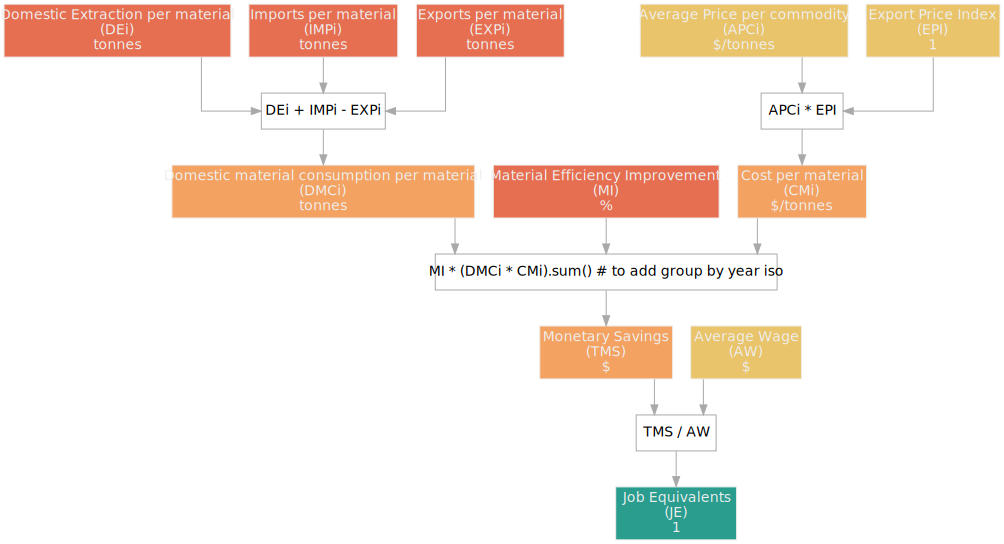

In [13]:
model.draw()

In [14]:
res['TMS'] * 1e-3

2248861966.9644628